# Dry Bulk Flows

## Run this example in [Colab](https://colab.research.google.com/github/SignalOceanSdk/SignalSDK/blob/master/docs/examples/jupyter/VoyagesAPI/DryBulkFlows.ipynb). 

## Setup
Install the Signal Ocean SDK:
```
pip install signal-ocean
```
Set your subscription key acquired here: https://apis.signalocean.com/profile

In [ ]:
!pip install signal-ocean

In [ ]:
signal_ocean_api_key = '' #replace with your subscription key

## Call the Voyages API
The Voyages API retrieves information about vessel voyages.

In [2]:
from signal_ocean import Connection
from signal_ocean.voyages import VoyagesAPI
import pandas as pd
from datetime import date, datetime
import plotly.express as px

In [3]:
connection = Connection(signal_ocean_api_key)
api = VoyagesAPI(connection)

Get vessel class ids for Dry  vessel classes

In [4]:
vessel_classes = api.get_vessel_classes()
vessel_classes_df = pd.DataFrame(v.__dict__ for v in vessel_classes)
vessel_classes_df[vessel_classes_df['vessel_type']=='Dry'].head(10)

,vessel_class_id,vessel_class_name,vessel_type_id,vessel_type
4,69,VLOC,3,Dry
5,70,Capesize,3,Dry
6,72,Post Panamax,3,Dry
7,74,Panamax,3,Dry
8,75,Supramax,3,Dry
9,76,Handymax,3,Dry
10,77,Handysize,3,Dry
19,92,Small,3,Dry


### Get voyages for Capesize
For Capesize we will use (vessel_class_id = 70) when calling the API

In [5]:
voyages = api.get_voyages_condensed(vessel_class_id=70, date_from=datetime.strptime("2021-09-01", "%Y-%m-%d"))
voyages = pd.DataFrame([v.__dict__ for v in voyages])
voyages.tail(5)

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,last_discharge_sailing_date,last_discharge_country_id,last_discharge_country_name,last_discharge_area_id_level0,last_discharge_area_name_level0,repairs_ind,storage_ind,sts_load_ind,sts_discharge_ind,local_trade_ind
22314,9974084,3,3,70,1,1072.0,False,None,I98314446VEDD103100,2,...,2024-03-29 01:31:24.704000+00:00,55.0,China,None,North China,False,False,False,False,False
22315,9974096,1,3,70,1,NaN,False,None,I98315046VEDC71FD00,2,...,2024-02-14 19:45:07.773000+00:00,121.0,Japan,None,Japan Island,True,False,False,False,False
22316,9974096,2,3,70,1,NaN,False,None,I98315046VEDD37BE00,3,...,2024-03-19 14:25:10.371000+00:00,55.0,China,None,North China,False,False,False,False,False
22317,9978573,1,3,70,1,NaN,False,None,I9842CD46VEDD37BE00,2,...,NaT,NaN,None,None,None,True,False,False,False,True
22318,9980174,1,3,70,1,NaN,False,None,I98490E46VEDD37BE00,2,...,NaT,NaN,None,None,None,True,False,False,False,True


Convert Timestamp to datetime, drop voyages with first_load_sailing_date in the future (ongoing or future)

In [6]:
voyages['first_load_sailing_date'] = voyages['first_load_sailing_date'].apply(lambda d : pd.to_datetime(d).tz_localize(None))
voyages=voyages[voyages['first_load_sailing_date']<datetime.now()]

## Examine Capesize Australia Capesize Coal Exports
Group by origin and destination (first load, last discharge), and use first_load_sailing_date as date of export

In [7]:
coal_exports_country_level = voyages[(voyages['first_load_sailing_date']>"2022-01-01")&(voyages['cargo_sub_group']=='Coal')] \
    .set_index('first_load_sailing_date') \
    .groupby(['first_load_country_name', 'last_discharge_country_name'])['quantity'] \
    .resample('MS') \
    .sum() \
    .reset_index() \
    .rename(columns={'first_load_sailing_date': 'Date'})

Drop intra country flows

In [8]:
coal_exports_country_level = coal_exports_country_level[coal_exports_country_level['first_load_country_name']!=coal_exports_country_level['last_discharge_country_name']]
coal_exports_country_level.head()

,first_load_country_name,last_discharge_country_name,Date,quantity
0,Australia,Belgium,2022-04-01,131000.0
1,Australia,Brazil,2022-01-01,315000.0
2,Australia,Brazil,2022-02-01,0.0
3,Australia,Brazil,2022-03-01,0.0
4,Australia,Brazil,2022-04-01,0.0


* Keep only Australia exports
* Aggregate all exports monthly
* Drop unnecessary columns

In [9]:
australia_coal_exports = coal_exports_country_level[(coal_exports_country_level['first_load_country_name']=='Australia')].copy()

australia_coal_exports['TotalExports'] = australia_coal_exports['quantity'].groupby(australia_coal_exports['Date']).transform('sum')
australia_coal_exports.drop_duplicates(subset=['Date'], keep='last', inplace = True)
australia_coal_exports.drop(['last_discharge_country_name', 'quantity'], axis=1, inplace = True)
australia_coal_exports.head()

,first_load_country_name,Date,TotalExports
383,Australia,2022-01-01,11198000.0
384,Australia,2022-02-01,10673000.0
385,Australia,2022-03-01,10345000.0
386,Australia,2022-04-01,9261000.0
387,Australia,2022-05-01,12362000.0


### Plot Australia Capesize Coal exports

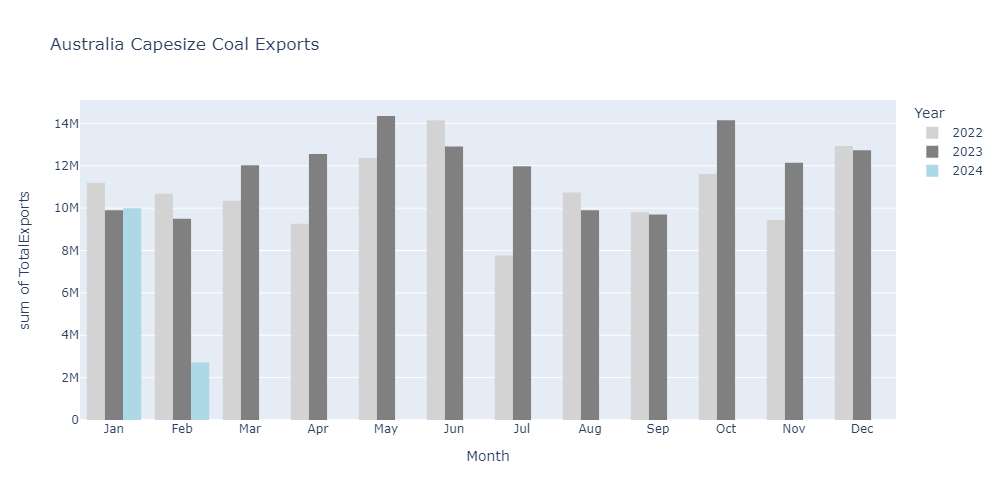

In [10]:
australia_coal_exports['Year'] = australia_coal_exports['Date'].apply(lambda date : date.year)
australia_coal_exports['Month'] = australia_coal_exports['Date'].apply(lambda date : date.month)
australia_coal_exports.sort_values(['Month', 'Year'], inplace = True)
australia_coal_exports['Month'] = australia_coal_exports['Date'].apply(lambda date : date.strftime("%b"))

fig = px.histogram(australia_coal_exports, x="Month", y="TotalExports", color='Year',
             barmode='group', height=500, width=1000,
             title='Australia Capesize Coal Exports',
             color_discrete_sequence=["lightgray", "gray", "lightblue"])
fig.show()

## Examine Australia to China Capesize Iron Ore Flows - Imports to China
Convert Timestamp to datetime, drop voyages with last_discharge_arrival_date in the future (ongoing or future voyages)

In [11]:
voyages['last_discharge_arrival_date'] = voyages['last_discharge_arrival_date'].apply(lambda d : pd.to_datetime(d).tz_localize(None))
voyages=voyages[voyages['last_discharge_arrival_date']<datetime.now()]
voyages.head()

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,last_discharge_sailing_date,last_discharge_country_id,last_discharge_country_name,last_discharge_area_id_level0,last_discharge_area_name_level0,repairs_ind,storage_ind,sts_load_ind,sts_discharge_ind,local_trade_ind
0,9123180,69,3,70,1,832.0,False,None,I8B356CVED8BCC500,1,...,2021-10-04 19:54:56+00:00,112.0,India,None,East Coast India,False,False,False,False,False
1,9123180,70,3,70,1,832.0,False,None,I8B356CVED8E45200,1,...,2021-11-27 23:58:17+00:00,112.0,India,None,East Coast India,False,False,False,False,False
2,9123180,71,3,70,1,832.0,False,None,I8B356CVED9336C00,1,...,2022-01-20 23:56:47+00:00,112.0,India,None,East Coast India,False,False,False,False,False
3,9123180,72,3,70,1,832.0,False,None,I8B356CVED95AF900,1,...,2022-01-31 19:57:54+00:00,112.0,India,None,East Coast India,False,False,False,False,True
4,9123180,73,3,70,1,832.0,False,None,I8B356CVED9828600,1,...,2022-02-11 19:57:47+00:00,112.0,India,None,East Coast India,False,False,False,False,True


* Keep only voyages with 'Iron Ore' as cargo group
* Group by origin and destination (first load, last discharge), and use last_discharge_arrival_date as date of flow

In [12]:
iron_ore_flows_country_level = voyages[(voyages['last_discharge_arrival_date']>"2022-01-01")&(voyages['cargo_sub_group']=='Iron Ore')] \
    .set_index('last_discharge_arrival_date') \
    .groupby(['first_load_country_name', 'last_discharge_country_name'])['quantity'] \
    .resample('MS') \
    .sum() \
    .reset_index() \
    .rename(columns={'last_discharge_arrival_date': 'Date'})
iron_ore_flows_country_level.head()

,first_load_country_name,last_discharge_country_name,Date,quantity
0,Australia,Australia,2022-01-01,310000.0
1,Australia,Australia,2022-02-01,164000.0
2,Australia,Australia,2022-03-01,139000.0
3,Australia,Australia,2022-04-01,420000.0
4,Australia,Australia,2022-05-01,145000.0


Keep only flows between Australia and China

In [13]:
china_australia_iron_ore_flows = iron_ore_flows_country_level[(iron_ore_flows_country_level['first_load_country_name']=='Australia')&(iron_ore_flows_country_level['last_discharge_country_name']=='China')].copy()
china_australia_iron_ore_flows.head()

,first_load_country_name,last_discharge_country_name,Date,quantity
26,Australia,China,2022-01-01,55255000.0
27,Australia,China,2022-02-01,41381000.0
28,Australia,China,2022-03-01,48940000.0
29,Australia,China,2022-04-01,47581000.0
30,Australia,China,2022-05-01,53061000.0


### Plot Australia to China Capesize Iron Ore Flows - Imports to China

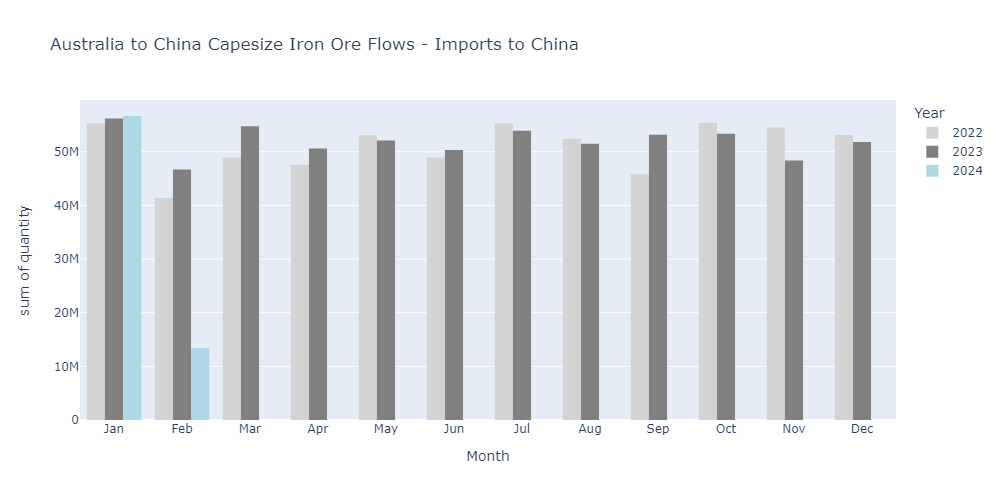

In [14]:
china_australia_iron_ore_flows['Year'] = china_australia_iron_ore_flows['Date'].apply(lambda date : date.year)
china_australia_iron_ore_flows['Month'] = china_australia_iron_ore_flows['Date'].apply(lambda date : date.month)
china_australia_iron_ore_flows.sort_values(['Month', 'Year'], inplace = True)
china_australia_iron_ore_flows['Month'] = china_australia_iron_ore_flows['Date'].apply(lambda date : date.strftime("%b"))

fig = px.histogram(china_australia_iron_ore_flows, x="Month", y="quantity", color='Year',
             barmode='group', height=500, width=1000,
             title='Australia to China Capesize Iron Ore Flows - Imports to China',
             color_discrete_sequence=["lightgray", "gray", "lightblue"])
fig.show()

## Build your custom Flows - Brazil Grain Exports to specific countries by Panamax and Supramax

Get vessel class ids for Dry vessel classes

In [15]:
vessel_classes = api.get_vessel_classes()
vessel_classes_df = pd.DataFrame(v.__dict__ for v in vessel_classes)
vessel_classes_df[vessel_classes_df['vessel_type']=='Dry'].head(10)

,vessel_class_id,vessel_class_name,vessel_type_id,vessel_type
4,69,VLOC,3,Dry
5,70,Capesize,3,Dry
6,72,Post Panamax,3,Dry
7,74,Panamax,3,Dry
8,75,Supramax,3,Dry
9,76,Handymax,3,Dry
10,77,Handysize,3,Dry
19,92,Small,3,Dry


### Select Vessel Classes of interest
Get voyages for selected vessel classes (Panamax and Supramax) starting from a given date

In [16]:
vessel_class_ids = (74, 75) # Get only voyages for Panamax and Supramax
date_from = datetime.strptime("2022-09-01", "%Y-%m-%d")

voyages = []
for vessel_class_id in vessel_class_ids:    
    voyages.append(api.get_voyages_condensed(vessel_class_id=vessel_class_id, date_from=date_from))
    
voyages = pd.DataFrame([v.__dict__ for vc in voyages for v in vc])
voyages.tail(5)

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,last_discharge_sailing_date,last_discharge_country_id,last_discharge_country_name,last_discharge_area_id_level0,last_discharge_area_name_level0,repairs_ind,storage_ind,sts_load_ind,sts_discharge_ind,local_trade_ind
68442,9984900,50,3,75,1,NaN,False,None,I985B844BVEDD44ED00,1,...,2024-02-07 05:20:21.777000+00:00,55.0,China,None,Central China,False,False,False,False,True
68443,9984900,51,3,75,1,NaN,False,None,I985B844BVEDD521C00,2,...,2024-02-15 21:53:37.775000+00:00,55.0,China,None,Central China,False,False,False,False,True
68444,9990818,1,3,75,1,NaN,False,None,I9872A24BVEDCE8A400,2,...,2024-03-14 18:15:56.194000+00:00,184.0,Philippines,None,Philippines,True,False,False,False,False
68445,9990832,1,3,75,1,NaN,False,None,I9872B04BVEDD37BE00,2,...,NaT,NaN,None,None,None,True,False,False,False,True
68446,9991513,1,3,75,1,NaN,False,None,I9875594BVEDCE8A400,2,...,2024-02-15 20:55:55.178000+00:00,55.0,China,None,Central China,True,False,False,False,False


Date of flows will be based on the export date
* Convert Timestamp to datetime, drop voyages with first_load_sailing_date in the future (ongoing or future)

In [17]:
voyages['first_load_sailing_date'] = voyages['first_load_sailing_date'].apply(lambda d : pd.to_datetime(d).tz_localize(None))
voyages=voyages[voyages['first_load_sailing_date']<datetime.now()]
voyages.head()

,imo,voyage_number,vessel_type_id,vessel_class_id,vessel_status_id,commercial_operator_id,deleted,events,id,horizon_id,...,last_discharge_sailing_date,last_discharge_country_id,last_discharge_country_name,last_discharge_area_id_level0,last_discharge_area_name_level0,repairs_ind,storage_ind,sts_load_ind,sts_discharge_ind,local_trade_ind
0,7514684,339,3,74,1,3968.0,False,None,I72AA3CVEDAA49000,1,...,2022-09-14 11:54:21+00:00,240.0,United States,None,Great Lakes,False,False,False,False,True
1,7514684,340,3,74,1,3968.0,False,None,I72AA3CVEDAB1BF00,1,...,2022-09-21 23:54:51+00:00,240.0,United States,None,Great Lakes,False,False,False,False,True
2,7514684,341,3,74,1,3968.0,False,None,I72AA3CVEDAB85680,1,...,2022-10-19 23:54:55+00:00,240.0,United States,None,Great Lakes,False,False,False,False,True
3,7514684,342,3,74,1,3968.0,False,None,I72AA3CVEDABEEE00,1,...,2022-10-27 19:54:27+00:00,240.0,United States,None,Great Lakes,False,False,False,False,True
4,7514684,343,3,74,1,3968.0,False,None,I72AA3CVEDAE67B00,1,...,2022-11-06 11:57:15+00:00,240.0,United States,None,Great Lakes,False,False,False,False,True


### Select cargo types of interest
Examine different cargo types under the "Grains" cargo group

In [18]:
voyages[(voyages['cargo_sub_group']=='Grains')&(voyages['cargo_type']!='Grains')].drop_duplicates(subset=['cargo_group', 'cargo_type'], keep='last', inplace = False)[['cargo_sub_group', 'cargo_type']].head(10)

,cargo_sub_group,cargo_type
68025,Grains,Barley
68296,Grains,Corn
68352,Grains,Rice
68360,Grains,Soybeans
68383,Grains,Sorghum
68384,Grains,Wheat


In [19]:
voyages[(voyages['first_load_country_name']=='Brazil')&(voyages['cargo_sub_group']=='Grains')]['cargo_type'].value_counts().head()

Soybeans    1650
Corn        1007
Wheat         38
Rice          14
Name: cargo_type, dtype: int64

* Keep only voyages with 'Soybeans' and 'Corn' as cargo type
* Group by origin and destination (first load, last discharge) and cargo type
* Use last_discharge_arrival_date as date of flow

In [20]:
cargo_types_of_interest = ('Soybeans', 'Corn')
custom_flows_country_level = voyages[(voyages['first_load_sailing_date']>"2023-01-01")&(voyages['cargo_type'].isin(cargo_types_of_interest))] \
    .set_index('first_load_sailing_date') \
    .groupby(['first_load_country_name', 'last_discharge_country_name', 'cargo_type'])['quantity'] \
    .resample('MS') \
    .sum() \
    .reset_index() \
    .rename(columns={'first_load_sailing_date': 'Date'})
custom_flows_country_level.head()

,first_load_country_name,last_discharge_country_name,cargo_type,Date,quantity
0,Algeria,Colombia,Corn,2023-01-01,40000.0
1,Algeria,Colombia,Corn,2023-02-01,0.0
2,Algeria,Colombia,Corn,2023-03-01,38000.0
3,Algeria,Colombia,Corn,2023-04-01,0.0
4,Algeria,Colombia,Corn,2023-05-01,0.0


### Select flows of interest
Keep only flows between Brazil and (China, South Korea, Japan)

In [21]:
import_countries = ('China', 'Korea, Republic of', 'Japan')
custom_flows = custom_flows_country_level[(custom_flows_country_level['first_load_country_name']=='Brazil')&(custom_flows_country_level['last_discharge_country_name'].isin(import_countries))].copy()
custom_flows.head()

,first_load_country_name,last_discharge_country_name,cargo_type,Date,quantity
493,Brazil,China,Corn,2023-01-01,559000.0
494,Brazil,China,Corn,2023-02-01,0.0
495,Brazil,China,Corn,2023-03-01,0.0
496,Brazil,China,Corn,2023-04-01,114000.0
497,Brazil,China,Corn,2023-05-01,187000.0


### Plot custom flows

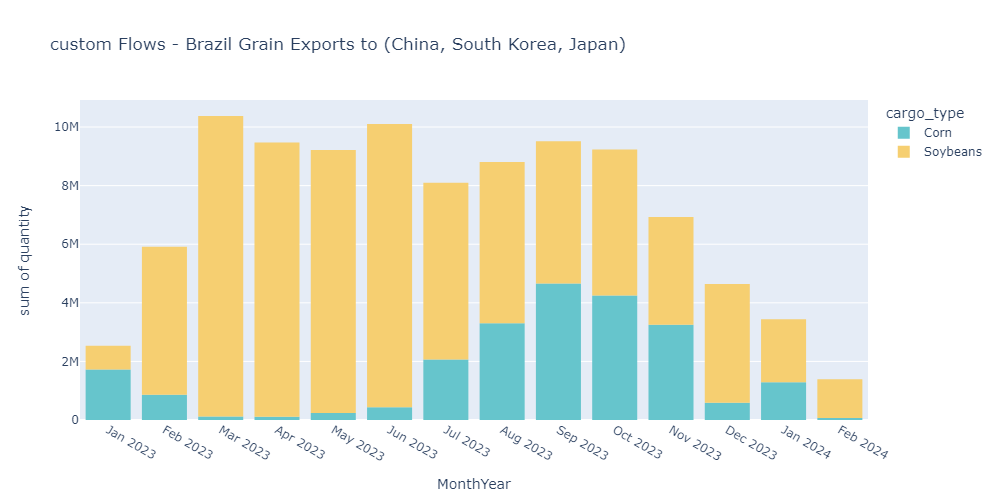

In [22]:
custom_flows['Year'] = custom_flows['Date'].apply(lambda date : date.year)
custom_flows['Month'] = custom_flows['Date'].apply(lambda date : date.month)
custom_flows.sort_values(['Year', 'Month'], inplace = True)

custom_flows['Month'] = custom_flows['Date'].apply(lambda date : date.strftime("%b"))
custom_flows['Year'] = custom_flows['Date'].apply(lambda date : date.strftime("%Y"))
custom_flows['MonthYear'] = custom_flows['Month'].astype(str) + ' ' + custom_flows['Year'].astype(str)

fig = px.histogram(custom_flows, x="MonthYear", y="quantity", color='cargo_type',
            height=500, width=1000, title='custom Flows - Brazil Grain Exports to (China, South Korea, Japan)',
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_layout(bargap=0.2)
fig.show()